## The Battle of Neighborhoods Part II
#### by Francisco J. O'Meany

In [2]:
import os
import numpy as np # library to handle data in a vectorized manner
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c conda-forge geocoder --yes
import geocoder

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries import completed.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [3]:
def getGeoLocation(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [31]:
def getNYVenues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '' # Foursquare ID
    CLIENT_SECRET = '' # Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    #print(results)
    #venue_data=results["response"]['groups'][0]['items']
    
    venue_data=[]
    if(results["response"]['groups']):
        venue_data=results["response"]['groups'][0]['items']
        
    
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [33]:
def getVenueDetails(venue_id):
        
    CLIENT_ID = '' # Foursquare ID
    CLIENT_SECRET = '' # Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
        
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [6]:
def getNYdata():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    NY_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        NY_data = NY_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return NY_data

In [7]:
# get new york data
NY_data=getNYdata()
# display dataframe head
NY_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
# display size of df
ny_size = NY_data.shape
print("The city of New York has "+str(ny_size[0])+ " neighborhoods")

The city of New York has 306 neighborhoods


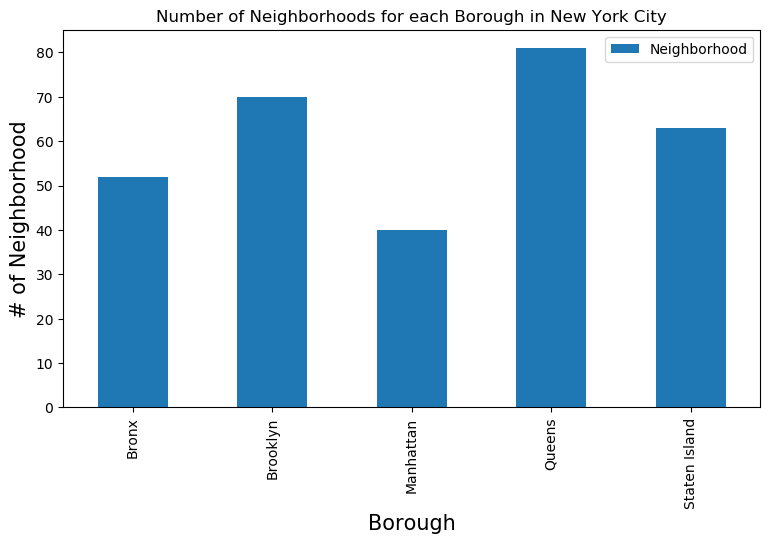

In [9]:
# visualize the number of neighborhoods in New York
plt.figure(figsize=(9,5), dpi = 100) # figure size
plt.title('Number of Neighborhoods for each Borough in New York City') # title
plt.xlabel('Borough', fontsize = 15) # legend x-axis
plt.ylabel('# of Neighborhood', fontsize=15) # legend y-axis
NY_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar') # bar plot
plt.legend() # legend
plt.show() # display plot

In [11]:
# prepare neighborhood list that contains Mexican restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
mex_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in NY_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = getNYVenues(Latitude,Longitude)
    #print(venues)
    mexican_restaurants=venues[venues['Category']=='Mexican Restaurant']   
    #print('(',count,'/',len(NY_data),')','Mexican Restaurants in '+Neighborhood+', '+Borough+':'+str(len(mexican_restaurants)))
    for rest_detail in mexican_restaurants.values.tolist():
        id, name , category=rest_detail
        mex_rest_ny = mex_rest_ny.append({'Borough': Borough,
                                          'Neighborhood': Neighborhood, 
                                          'ID': id,
                                          'Name' : name
                                          }, ignore_index=True)
    count+=1

In [12]:
# Mexican restaurant list
mex_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar
4,Bronx,Fieldston,5ce9664e3731ee002baae6ed,Estrellita Poblana


In [13]:
# size of Mexican restaurants dataframe
numOfRest = mex_rest_ny.shape
# display the number of restaurants found
print('We found '+str(numOfRest[0])+ ' Mexican restaurants in New York City')

We found 326 Mexican restaurants in New York City


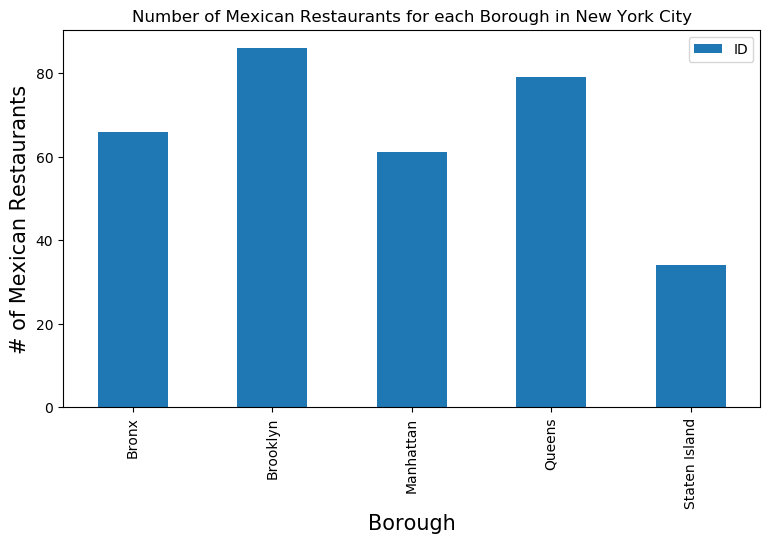

In [14]:
# Display plot with the number of Mexican restaurants for each Borough
plt.figure(figsize=(9,5), dpi = 100) # figure size
plt.title('Number of Mexican Restaurants for each Borough in New York City') # title
plt.xlabel('Borough', fontsize = 15) # legend x-axis
plt.ylabel('# of Mexican Restaurants', fontsize=15) # legend y-axis
mex_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar') # bar plot
plt.legend() # legend
plt.show() # display plot

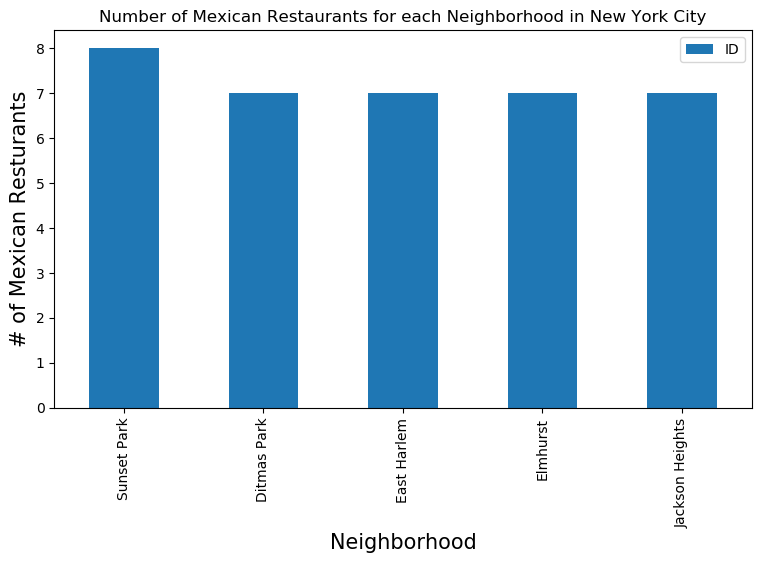

In [15]:
# Display plot with the number of Mexican restaurants for each Neighborhood
plt.figure(figsize=(9,5), dpi = 100) # figure size
plt.title('Number of Mexican Restaurants for each Neighborhood in New York City') # title
plt.xlabel('Neighborhood', fontsize = 15) # legend on x-axis
plt.ylabel('# of Mexican Resturants', fontsize=15) # legend on y-axis
mex_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar') # bar plot
plt.legend() # legend
plt.show() # display plot

In [16]:
# display the largest neighborhood with Mexican restaurants
mex_rest_ny[mex_rest_ny['Neighborhood']=='Sunset Park']

,Borough,Neighborhood,ID,Name
64,Brooklyn,Sunset Park,49bc364ff964a5201f541fe3,Tacos Matamoros
65,Brooklyn,Sunset Park,4b5415ecf964a520d3b127e3,Ricos Tacos
66,Brooklyn,Sunset Park,4b5cff55f964a520424e29e3,Maria's Bistro Mexicano
67,Brooklyn,Sunset Park,4c9521df82b56dcbc5fbd5aa,Tacos El Bronco
68,Brooklyn,Sunset Park,4d6d976d792bb60cbdd156be,Tulcingo Restaurant
69,Brooklyn,Sunset Park,4bc25f7c461576b0fd5d7d32,Puebla Mini Market / Tortas a la Plancha Don Pepe
70,Brooklyn,Sunset Park,55a85c0f498ee3c735f1fa8d,Jalapeño Restaurant
71,Brooklyn,Sunset Park,4aa30695f964a520094320e3,Casa Vieja Restaurant


In [32]:
# prepare neighborhood list that contains Mexican restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
mex_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in mex_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=getVenueDetails(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        # recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    #print('(',count,'/',len(mex_rest_ny),')','processed')
    mex_rest_stats_ny = mex_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '5e331c4414a126001bf8eaa0'}, 'response': {'venue': {'id': '5c47a4b21953f3002c558218', 'name': 'Chipotle Mexican Grill', 'contact': {'phone': '3478998442', 'formattedPhone': '(347) 899-8442', 'twitter': 'chipotletweets', 'facebook': '1948155241949419', 'facebookUsername': 'ChipotleBayPlaza', 'facebookName': 'Chipotle Mexican Grill'}, 'location': {'address': '2122 Bartow Avenue, Unit #116', 'lat': 40.868854, 'lng': -73.82627, 'labeledLatLngs': [{'label': 'display', 'lat': 40.868854, 'lng': -73.82627}], 'postalCode': '10475', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2122 Bartow Avenue, Unit #116', 'Bronx, NY 10475', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chipotle-mexican-grill/5c47a4b21953f3002c558218', 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralName': 'Mexican Restaurants', 'shortName': 'Mexican', 'icon': {'prefix': 'https://ss3.4sqi.n

KeyError: 'venue'

In [34]:
# display the first 5 rows of the Mexican restaurants statistics
mex_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill,0,7.5,0
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill,1,6.5,0
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop,10,7.0,4
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar,11,6.0,17
4,Bronx,Fieldston,0,0,0,0.0,0


In [36]:
# size of Mexican restaurants statistics dataframe
mex_rest_stats_ny.shape


(326, 4)

In [37]:
# size of Mexican restaurants in New York City
mex_rest_ny.shape

(326, 4)

In [38]:
# save the Mexican restaurants statistics dataframe to a csv file to prevent multiple calls to FourSquare which has a limit of 500 a day
mex_rest_stats_ny.to_csv('MexicanRestaurantStatisticsNY.csv', index=False)

In [39]:
# verify saved csv file
mex_rest_stats_ny_csv=pd.read_csv('MexicanRestaurantStatisticsNY.csv')

In [40]:
# verify size of dataframe
mex_rest_stats_ny_csv.shape

(50, 7)

In [41]:
# display first 5 rows
mex_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill,0,7.5,0
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill,1,6.5,0
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop,10,7.0,4
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar,11,6.0,17
4,Bronx,Fieldston,0,0,0,0.0,0


In [42]:
# display dataframe info
mex_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


In [43]:
# convert 'Likes' to a float type for analysis
mex_rest_stats_ny['Likes']=mex_rest_stats_ny['Likes'].astype('float64')

In [44]:
# convert 'Tips' to a float type for analysis
mex_rest_stats_ny['Tips']=mex_rest_stats_ny['Tips'].astype('float64')

In [45]:
# display new dataframe info
mex_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [46]:
# Restaurant with maximum 'Likes'
mex_rest_stats_ny.iloc[mex_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                131
Rating                               9.1
Tips                                  73
Name: 42, dtype: object

In [47]:
# Restaurant with maximum 'Rating'
mex_rest_stats_ny.iloc[mex_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                131
Rating                               9.1
Tips                                  73
Name: 42, dtype: object

In [48]:
# Restaurant with maximum 'Tips'
mex_rest_stats_ny.iloc[mex_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                131
Rating                               9.1
Tips                                  73
Name: 42, dtype: object

In [49]:
# display maximum average ratings by neighborhood of Mexican restaurants
ny_neighborhood_stats=mex_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
19,Westchester Square,8.500000
11,Morris Park,8.500000
15,Parkchester,8.450000
18,University Heights,8.000000
9,Marble Hill,8.000000
16,Riverdale,7.950000
4,Country Club,7.900000
7,Kingsbridge,7.783333
17,Spuyten Duyvil,7.550000
2,Belmont,7.500000


In [50]:
# display maximum average ratings by borough of Mexican restaurants
ny_borough_stats=mex_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Average Rating
1,Manhattan,8.000000
0,Bronx,7.144681


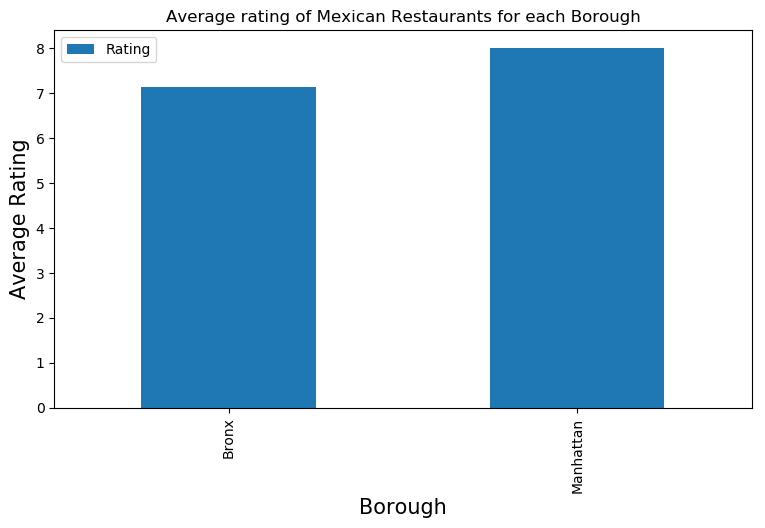

In [51]:
# show the average rating of Mexican restaurants in New York City
plt.figure(figsize=(9,5), dpi = 100) # size of figure
plt.title('Average rating of Mexican Restaurants for each Borough') # title
plt.xlabel('Borough', fontsize = 15) # legend on x-axis
plt.ylabel('Average Rating', fontsize=15) # legend on y-axis
mex_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar') # bar plot
plt.legend() # legend
plt.show() # show plot

In [52]:
# display neighborhood average ratings
ny_neighborhood_average=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_average

,Neighborhood,Average Rating
0,Baychester,7.000000
1,Bedford Park,7.250000
2,Belmont,7.500000
3,Co-op City,7.000000
4,Country Club,7.900000
6,Fordham,7.300000
7,Kingsbridge,7.783333
9,Marble Hill,8.000000
11,Morris Park,8.500000
12,Morrisania,7.500000


In [53]:
# display borough average ratings
ny_borough_average=ny_borough_stats[ny_borough_stats['Average Rating']>=7.0]
ny_borough_average

,Borough,Average Rating
0,Bronx,7.144681
1,Manhattan,8.000000


In [54]:
# merge dataframe with original df to obtain latitude and longitude and display result dataframe
ny_neighborhood_merged=pd.merge(ny_neighborhood_stats,NY_data, on='Neighborhood')
ny_neighborhood_merged_df=ny_neighborhood_merged[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_merged_df

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Baychester,40.866858,-73.835798,7.000000
1,Bronx,Bedford Park,40.870185,-73.885512,7.250000
2,Bronx,Belmont,40.857277,-73.888452,7.500000
3,Bronx,Co-op City,40.874294,-73.829939,7.000000
4,Bronx,Country Club,40.844246,-73.824099,7.900000
5,Bronx,Fieldston,40.895437,-73.905643,4.333333
6,Bronx,Fordham,40.860997,-73.896427,7.300000
7,Bronx,Kingsbridge,40.881687,-73.902818,7.783333
8,Bronx,Longwood,40.815099,-73.895788,6.850000
9,Manhattan,Marble Hill,40.876551,-73.910660,8.000000


In [55]:
# create map and display it
ny_map = folium.Map(location=getGeoLocation('New York'), zoom_start=12)

In [56]:
# instantiate a feature group
ny_group = folium.map.FeatureGroup()

# loop through the dataframe and add each row to the feature group
for lat, lng, in ny_neighborhood_merged_df[['Latitude','Longitude']].values:
    ny_group.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [57]:
# add new column for labeling
ny_neighborhood_merged_df=pd.DataFrame(ny_neighborhood_merged_df)
ny_neighborhood_merged_df['Label']=ny_neighborhood_merged_df['Neighborhood']+', '+ny_neighborhood_merged_df['Borough']+'('+ny_neighborhood_merged_df['Average Rating'].map(str)+')'

In [58]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_merged_df[['Latitude','Longitude', 'Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(ny_group)

In [60]:
!wget -O Borough_Boundaries.geojson https://francisco.omeany.net/Borough_Boundaries.geojson

--2020-01-30 18:24:23--  https://francisco.omeany.net/Borough_Boundaries.geojson
Resolving francisco.omeany.net (francisco.omeany.net)... 192.254.157.172
Connecting to francisco.omeany.net (francisco.omeany.net)|192.254.157.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2949497 (2.8M)
Saving to: ‘Borough_Boundaries.geojson’

100%[======================================>] 2,949,497   1.99MB/s   in 1.4s   

2020-01-30 18:24:25 (1.99 MB/s) - ‘Borough_Boundaries.geojson’ saved [2949497/2949497]



In [63]:
ny_borough_map = folium.Map(location=getGeoLocation('New York'), zoom_start=12)
ny_borough_geo = r'Borough_Boundaries.geojson'
#ny_borough_geo = r'ny_borough_boundaries.json'

ny_borough_map.choropleth(
    geo_data=ny_borough_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# big map, save it to a file
ny_borough_map.save('mex_rest_borough_rating.html')